In [1]:
import xrft
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from matplotlib import colors, ticker, cm
from xhistogram.xarray import histogram 
import pandas as pd
from matplotlib import colors as cols

In [2]:
import matplotlib 
font = {'family' : 'sans-serif',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
npick = 4*1 # num of files per day * ndays we want output = 4*1
dt_out = 72 # output frequency/ dt = 21600/300
T1 =  10394208 # 3months + 1 day
T2months = 10406880 # 4.5 months

iters = range(T1, T2months, dt_out*npick)

data_dir = '/swot/SUM05/dbalwada/channel_beta/05km/tracer_exp1/' 

ds = open_mdsdataset(data_dir, delta_t=300, iters= iters, 
                            prefix=['U','V','W','PTRACER01','tracer1_diag']
                     ,ignore_unknown_vars=True, geometry='cartesian')

In [4]:
hab01L = xr.open_dataarray('/home/qx344/data/hab01-longtime')
hab05L = xr.open_dataarray('/home/qx344/data/hab05-longtime')
vortold = np.linspace(-7, 7, 240)
strainold = np.linspace(.5e-3, 7, 240)
binbox01old =  (vortold[1]-vortold[0])*(strainold[1]-strainold[0])

In [5]:
horispace = 5e3
time_index = 0
f =  -0.83e-4
X = ds.XC/1e3
Y = ds.YC/1e3
daytime = 86400
ybound = 5e5

In [6]:
grid = Grid(ds, periodic='X')

In [8]:
vort_1d = grid.interp(grid.interp((grid.diff(ds.V, 'X') - grid.diff(ds.U, 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace

strain_1d = ((grid.diff(ds.U, 'X') - grid.diff(ds.V, 'Y', boundary='extend'))**2 + 
          (grid.interp(grid.interp(grid.diff(ds.V, 'X') + grid.diff(ds.U, 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace

In [9]:
vort_1d = vort_1d.sel(YC = slice(ybound,2e6-ybound)).isel(Z=0)
strain_1d = strain_1d.sel(YC = slice(ybound,2e6-ybound)).isel(Z=0)
vort_1d = (vort_1d/f).rename('vort1_0')
strain_1d = (abs(strain_1d/f)).rename('strain1_0')

In [10]:
vort_1d.load();
strain_1d.load();

In [11]:
diffusion = grid.interp(ds.DFrITr01, 'Z', boundary='extend')

In [12]:
vortband01 = np.linspace(-7, 7, 240)
strainband01 = np.linspace(.5e-3, 7, 240)

binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])

In [13]:
mask_c = xr.where(hab01L.vort1_0_bin>hab01L.strain1_0_bin,1,0)
mask_ac = xr.where(-hab01L.vort1_0_bin>hab01L.strain1_0_bin,1,0)
mask_f = xr.where(abs(hab01L.vort1_0_bin)<=hab01L.strain1_0_bin,1,0)

In [14]:
DifZup = np.zeros([76])
DifZmid = np.zeros([76])
DifZac = np.zeros([76])
DifZc = np.zeros([76])
for depthInd in range(76):
    diffusionDepth = grid.interp(ds.DFrITr01, 'Z', boundary='extend').isel(Z=depthInd).sel(YC = slice(ybound,2e6-ybound)).rename('diff01')
    diffusionDepth.load()

    hab01_Diff = histogram(vort_1d, strain_1d, weights = diffusionDepth, dim = ['XC','YC'] , bins=[vortband01,strainband01])
    hab01_Difftm = hab01_Diff.mean(dim='time')
    hab01_Difftm.load()
    DifZac[depthInd] = (hab01_Difftm*mask_ac).sum().values[()]/(1000**2)
    DifZc[depthInd] = (hab01_Difftm*mask_c).sum().values[()]/(1000**2)
    DifZmid[depthInd] = (hab01_Difftm*mask_f).sum().values[()]/(1000**2)
    print(depthInd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


(-20.0, 20.0)

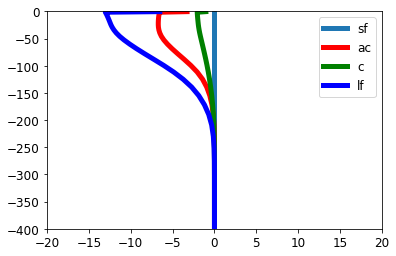

In [15]:
plt.plot(DifZup, ds.Z.values, linewidth = 5)
plt.plot(DifZac, ds.Z.values, linewidth = 5,color = 'r')
plt.plot(DifZc, ds.Z.values, linewidth = 5,color ='g')
plt.plot(DifZmid, ds.Z.values, linewidth = 5,color ='b')

plt.legend(['sf','ac','c','lf'])
plt.ylim(-400,0)
plt.xlim(-20,20)

In [16]:
surfTracer = ds.PTRACER01
#surfTracer_pos = xr.where((1-surfTracer).isel(Z=0)<0, 0, (1-surfTracer).isel(Z=0) )
#sorfForce = surfTracer_pos.sel(YC = slice(ybound,2e6-ybound))/(72*60)
sorfForce = (1-surfTracer).isel(Z=0).sel(YC = slice(ybound,2e6-ybound))/(72*60)

#sorfForce = sorfForce.chunk({'XC': 2000, 'YC': 2000, 'time':40})

hab05_1SF = histogram(vort_1d,strain_1d, weights = sorfForce, dim = ['XC','YC'] , bins=[vortband01,strainband01])
hab05_1SF.load();

In [17]:
SFac = (hab05_1SF.mean(dim='time')*mask_ac).sum().values[()]
SFc= (hab05_1SF.mean(dim='time')*mask_c).sum().values[()]
SFmid = (hab05_1SF.mean(dim='time')*mask_f).sum().values[()]

In [18]:
print(SFac,SFc,SFmid)

0.25681221263547394 0.08150786053795972 0.5292262059893121
